In [1]:
import keras
import numpy as np
from tqdm import tqdm_notebook
from grcnn.data_generation import BatchGenerator, Path
from grcnn.model import GRCNN, mean_squared_error
from grcnn.training import get_transforms
from grcnn.utils import calc_metric, find_and_load_model, load_model_grcnn
from pylibs import img_utils
from pylibs.pandas_utils import DF_FILE_FORMAT, read_dataframe

Using TensorFlow backend.


In [2]:
width, height = 64, 32
n_classes = 10
max_text_len = 17
grcl_niter = 3
grcl_fsize = 3
lstm_units = 512

In [4]:
model = GRCNN(height, width, n_classes, max_text_len, grcl_niter, grcl_fsize, lstm_units)
# path = '/srv/data_science/training/checkpoints/price_ocr/model5/epoch_35_val_leven0.211800.hdf5'
# model.load_weights(path)

In [3]:
model_num = 23
epoch = 23
model = load_model_grcnn(model_num, epoch, height, width, n_classes, max_text_len, grcl_niter, grcl_fsize, lstm_units)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [7]:
import numpy as np

In [11]:
np.any([np.any(np.isinf(x)) for x in model.get_weights()])

False

In [9]:
len(model.layers)

80

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 32, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 32, 64, 64)   1792        input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 32, 64, 64)   256         conv2d_15[0][0]                  
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  multiple             0           batch_normalization_27[0][0]     
                                                                 batch_normalization_29[0][0]     
          

In [3]:
lr = 0.0001  # depends on optimizer
optimizer = keras.optimizers.Adam(lr=lr)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred, 'predictions': None}, optimizer=optimizer)

In [31]:
batch_size = 64
train_augment_prob = 0.5
seed = 42
max_text_len = 26
dataset_dir_str = '/srv/data_science/storage/product_code_ocr'
dataset_dir_path = Path(dataset_dir_str)
image_dir = 'images_train2'
images_dir_path = dataset_dir_path / image_dir

df_name = 'bad_samples'
bad_samples_path = dataset_dir_path / (DF_FILE_FORMAT % df_name)
bad_samples_df = read_dataframe(bad_samples_path)

df_name = 'train_set'
train_set_path = dataset_dir_path / (DF_FILE_FORMAT % df_name)
train_df = read_dataframe(train_set_path)
index = list(set(train_df.index) & set(bad_samples_df.index))
train_df = train_df.loc[index, :]
# train_gen = BatchGenerator(train_df, batch_size, images_dir_path, max_text_len,
#                            transform_list, train_augment_prob, seed=seed)
train_gen = BatchGenerator(train_df, batch_size, images_dir_path, max_text_len)
ALPHABET = "".join(map(str, range(10))) + '-'

In [33]:
batch_x, batch_y = next(train_gen)

In [ ]:
debug = False
for _ in tqdm_notebook(range(6000)):
    loss, pred = model.predict_on_batch(batch_x)6
    dists = []
    for sample, text, label in zip(pred,  batch_x['texts'], batch_x['labels']):
        dist = calc_metric(sample, text, ALPHABET, debug=debug)
        dists.append(dist)
        if debug and dist > 0:
            print("Labels:", "".join('•' if x == 10 else str(x) for x in map(int, label)))
    loss = model.train_on_batch(batch_x, batch_y)
    print(f"%.3f %.3f" % (np.mean(dists), loss[0]), sep=' ', end='\r', flush=True)

In [39]:
debug = 1
loss, pred = model.predict_on_batch(batch_x)
dists2 = []
for sample, text, label in zip(pred,  batch_x['texts'], batch_x['labels']):
    dist = calc_metric(sample, text, ALPHABET, debug=debug)
    dists2.append(dist)
    if debug and dist > 0:
        print("Labels:", "".join('•' if x == len(ALPHABET) else str(x) for x in map(int, label)))

True 4603567000238
Pred argmax 46600335567700000000022388
it0. Pred [ 6 11  4] [0.028 0.06  0.715]
it1. Pred [11  4  6] [0.03  0.436 0.436]
it2. Pred [4 0 6] [0.053 0.054 0.736]
it3. Pred [11  6  0] [0.028 0.428 0.45 ]
it4. Pred [11  3  0] [0.04  0.081 0.743]
it5. Pred [11  0  3] [0.041 0.11  0.713]
it6. Pred [11  5  3] [0.046 0.129 0.679]
it7. Pred [ 3 11  5] [0.025 0.043 0.79 ]
it8. Pred [11  6  5] [0.039 0.225 0.605]
it9. Pred [11  7  6] [0.077 0.117 0.544]
it10. Pred [ 6 11  7] [0.023 0.047 0.77 ]
it11. Pred [11  0  7] [0.258 0.325 0.347]
it12. Pred [ 7 11  0] [0.039 0.414 0.467]
it13. Pred [ 7 11  0] [0.009 0.453 0.461]
it14. Pred [ 7 11  0] [0.008 0.457 0.458]
it15. Pred [ 7 11  0] [0.008 0.458 0.458]
it16. Pred [ 7 11  0] [0.008 0.458 0.458]
it17. Pred [ 2 11  0] [0.008 0.458 0.458]
it18. Pred [ 2 11  0] [0.008 0.457 0.459]
it19. Pred [ 2 11  0] [0.009 0.451 0.463]
it20. Pred [ 2 11  0] [0.102 0.105 0.669]
it21. Pred [11  0  2] [0.048 0.075 0.741]
it22. Pred [11  3  2] [0.029 0.

In [40]:
np.sum(np.array(dists2)==0), len(dists2), np.mean(dists2), np.median(dists2)

(11, 64, 1.859375, 2.0)

In [ ]:
debug = True
for i, (batch_x, batch_y) in tqdm_notebook(enumerate(train_gen)):
    loss, pred = model.predict_on_batch(batch_x)
    dists = []
    for sample, text, label in zip(pred,  batch_x['texts'], batch_x['labels']):
        dist = calc_metric(sample, text, ALPHABET, debug=debug)
        dists.append(dist)
        if debug and dist > 0:
            print("Labels:", "".join('•' if x == 10 else str(x) for x in map(int, label)))
    print(np.mean(dists), np.mean(loss))
    if np.any(np.isnan(loss)) or np.any(np.isinf(loss)):
        print("Predict. Bad loss", loss, "index", i)
        break
    loss = model.train_on_batch(batch_x, batch_y)
    if np.any(np.isnan(loss)) or np.any(np.isinf(loss)):
        print("Train. Bad loss", loss, "index", i)
        break

In [7]:
loss = model.predict_on_batch(batch_x)

In [32]:
np.where(loss[0] == np.inf)

(array([38]), array([0]))

In [11]:
loss[1].shape

(64, 26, 11)

In [34]:
batch_x['the_labels'][38]

array([ 4.,  6.,  8.,  0.,  0.,  3.,  6.,  9.,  1.,  1.,  8.,  6.,  8.,
        0.,  0.,  0.,  4.,  9.,  9.,  0.,  2.,  0.,  1.,  0.,  8., 10.],
      dtype=float32)

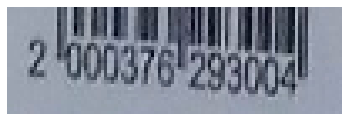

In [28]:
img = (batch_x['the_input'][37]+1)/2
img_utils.show_img(img)

In [21]:
batch_x['label_length'][38]

25.0

In [ ]:
for i, vec in enumerate(batch_x["the_labels"]):
    print(i, np.sum(vec!=10.))